# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

#from sklearn.cross_validation import train_test_split
import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
#import scikitplot as skplt
import sklearn as skplt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing as preprocessing
from sklearn.metrics import roc_curve, auc

In [0]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


#parti
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [04:20<00:00, 1399.16it/s]


In [0]:
final['CleanedText']=preprocessed_reviews #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [0]:
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [0]:
con = sqlite3.connect("final.sqlite")
final = pd.read_sql_query("""SELECT * FROM Reviews""",con)

In [0]:
final.sort_values("Time",ascending=True, inplace=True, kind='quicksort')

In [0]:
final['Score'].replace(['negative', 'positive'],[0,1],inplace=True)

In [0]:
final = final.to_csv("final.csv")

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

### Taking 100K Points

In [0]:
!wget --header="Host: doc-04-7o-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://drive.google.com/drive/my-drive" --header="Cookie: AUTH_bbgisrjd8bh8hpacul6ehoeo57pe3ls5_nonce=l3un460v2u54u; NID=146=N2VUi0lepHBhQnZcDuxOWJ4hXdwTBZruYY7zo8PbBbxhYIFI-xCCWRXhSuwhnB019ME0O4VGJUoAlHJ-egd-vYsvB0g16qHzVEBVSumLonesaFXpe-vfJzXJWJvgjxyEhPsPVZvNe_wKZW2TKaQUx7s1nG_4XPOfzucfhds6ahk" --header="Connection: keep-alive" "https://doc-04-7o-docs.googleusercontent.com/docs/securesc/mei7dm6hud0723bm1f9k9h0820psmb7u/lvcje3f484i1khsqu5hnt3oqnfnt6nuk/1549166400000/07269277556108957290/07269277556108957290/1N5iKXvZ-BqO7KDkxBr0DxjSmx5go4f1P?e=download&nonce=l3un460v2u54u&user=07269277556108957290&hash=bnc0jl5g3mf7qut43oh5mlrr8rueg27k" -O "final.csv" -c

--2019-02-03 07:40:15--  https://doc-04-7o-docs.googleusercontent.com/docs/securesc/mei7dm6hud0723bm1f9k9h0820psmb7u/lvcje3f484i1khsqu5hnt3oqnfnt6nuk/1549166400000/07269277556108957290/07269277556108957290/1N5iKXvZ-BqO7KDkxBr0DxjSmx5go4f1P?e=download&nonce=l3un460v2u54u&user=07269277556108957290&hash=bnc0jl5g3mf7qut43oh5mlrr8rueg27k
Resolving doc-04-7o-docs.googleusercontent.com (doc-04-7o-docs.googleusercontent.com)... 74.125.141.132, 2607:f8b0:400c:c06::84
Connecting to doc-04-7o-docs.googleusercontent.com (doc-04-7o-docs.googleusercontent.com)|74.125.141.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘final.csv’

final.csv               [         <=>        ] 264.58M   149MB/s    in 1.8s    

2019-02-03 07:40:17 (149 MB/s) - ‘final.csv’ saved [277430966]



In [0]:
final = pd.read_csv("final.csv") # reading csv file

In [0]:
final = final.iloc[:100000] #taking 50k point

In [0]:
X = final["CleanedText"]
y = final["Score"]

In [0]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


# [4] Featurization

## A.) [4.1] BAG OF WORDS

In [0]:
#Bow
count = CountVectorizer(min_df=10) 

Bow_train = count.fit_transform(X_train)

Bow_test = count.transform(X_test)


In [0]:
# Create the Scaler object
#scaler = preprocessing.StandardScaler(with_mean=False)
# Fit your data on the scaler object
#Bow_train = scaler.fit_transform(Bow_train)
#Bow_test = scaler.transform(Bow_test)

#Normalize Data
Bow_train = preprocessing.normalize(Bow_train)
print("Train Data Size: ",Bow_train.shape)

#Normalize Data
Bow_test = preprocessing.normalize(Bow_test)
print("Test Data Size: ",Bow_test.shape)

Train Data Size:  (70000, 7154)
Test Data Size:  (30000, 7154)


## B.) [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_train = tf_idf_vect.fit_transform(X_train)
tf_idf_test = tf_idf_vect.transform(X_test)

In [0]:
tf_idf_train = preprocessing.normalize(tf_idf_train)
print("Train Data Size: ",tf_idf_train.shape)

#Normalize Data
tf_idf_test = preprocessing.normalize(tf_idf_test)
print("Test Data Size: ",tf_idf_test.shape)

Train Data Size:  (70000, 40525)
Test Data Size:  (30000, 40525)


## C.) [4.4] Word2Vec

In [0]:
#url for the GoogleNews word2vec model
url="https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [0]:
#downloading the GoogleNews word2vec 
import urllib
urllib.request.urlretrieve (url, "GoogleNews-vectors-negative300.bin.gz")

('GoogleNews-vectors-negative300.bin.gz',
 <http.client.HTTPMessage at 0x7ff807902cc0>)

In [0]:
# import modules & set up logging
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [0]:
#loading the GoogleNews word2vec model(able to read bin.gz file directly, no need to extract)
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

2019-02-03 07:42:31,163 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin.gz
2019-02-03 07:44:37,773 : INFO : loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin.gz


In [0]:

#getting the list of sentences in a 'list'
i=0

list_of_sentences=[]
for sent in X_train.values:
    filtered_sentence=[]    
    for w in sent.split():
        #w=w.decode('utf-8')
        if (w==sent.split()[0]):
            w=w[2:]
        filtered_sentence.append(w.lower())       
    list_of_sentences.append(filtered_sentence)
    
print(len(list_of_sentences))

70000


In [0]:
words=list(model.wv.vocab)
print(len(words))

3000000


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
#calculating avg word2vec
vectors=[];
for sentence in list_of_sentences:
    sentence_vector=np.zeros(300)
    count_vec=0;
    for word in sentence:
        try:
            vec=model.wv[word]
            sentence_vector+=vec
            count_vec+=1;
        except:
            pass
    sentence_vector/=count_vec
    vectors.append(sentence_vector)

In [0]:
z=list(np.unique(np.where(np.isnan(vectors))[0]))
z

[]

In [0]:
#calculating avg word2vec
x_test_word=[];
for sentence in X_test.values:
    sentence_vector=np.zeros(300)
    count_vec=0;
    for word in sentence.split():
        if(word==sentence.split()[0]):
            word=word[2:]
        
        try:
            vec=model.wv[word]
            sentence_vector+=vec
            count_vec+=1;
        except:
            pass
    sentence_vector/=count_vec
    x_test_word.append(sentence_vector)

    
print(len(x_test_word))

30000


In [0]:
#checking row containing nan value
z=list(np.unique(np.where(np.isnan(x_test_word))[0]))
z

[]

In [0]:
#Normalize Data
avg_train = preprocessing.normalize(vectors)
print("Train Data Size: ",avg_train.shape)

avg_test = preprocessing.normalize(x_test_word)
print("Test Data Size: ",avg_test.shape)


Train Data Size:  (70000, 300)
Test Data Size:  (30000, 300)


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

tfidf=TfidfVectorizer(ngram_range=(1,1))
x_train_tfidf=tfidf.fit_transform(X_train.values)
x_test_tfidf=tfidf.transform(X_test.values)

dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))

In [0]:

features=tfidf.get_feature_names()
len(features)

31561

In [0]:
#calculating tf-idf w2vec
tfidf_vectors = []; 
row=0;
for sentence in tqdm(list_of_sentences): 
    sentence_vec = np.zeros(300) 
    weight_sum =0; 
    for word in sentence: 
        try:
            vec = model.wv[word]
            tf_idf = x_train_tfidf[row, features.index(word)]
            sentence_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sentence_vec /= weight_sum
    tfidf_vectors.append(sentence_vec)
    row += 1
    
print(len(tfidf_vectors))

100%|██████████| 70000/70000 [18:46<00:00, 62.12it/s]

70000


In [0]:
z=list(np.unique(np.where(np.isnan(tfidf_vectors))[0]))
z

[22301, 29916, 37944]

In [0]:
y_train_word=np.array(y_train)
y_train_word=np.delete(y_train_word, z, axis=0)
y_test=np.array(y_test)

y_test_word=np.delete(y_test, z, axis=0)

tfidf_vectors=np.delete(tfidf_vectors, z, axis=0)


In [0]:
print(len(tfidf_vectors))

69997


In [0]:
#calculating tf-idf w2vec
x_test_tf_word = []; 
row=0;
for sentence in X_test.values: 
    sentence_vec = np.zeros(300) 
    weight_sum =0; 
    for word in sentence.split():
        if(word==sentence.split()[0]):
            word=word[2:]
        
        try:
            vec = model.wv[word]
            tf_idf = x_test_tfidf[row, features.index(word)]
            sentence_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sentence_vec /= weight_sum
    x_test_tf_word.append(sentence_vec)
    row += 1

In [0]:
print(len(x_test_tf_word))

30000


In [0]:
z=list(np.unique(np.where(np.isnan(x_test_tf_word))[0]))
z

[14058, 17126]

In [0]:
x_test_tf_word=np.delete(x_test_tf_word, z , axis=0)
len(x_test_tf_word)

29998

In [0]:
#Normalize Data
w2v_tfidf_train = preprocessing.normalize(tfidf_vectors)
print("Train Data Size: ",w2v_tfidf_train.shape)

w2v_tfidf_test = preprocessing.normalize(x_test_tf_word)
print("Test Data Size: ",w2v_tfidf_test.shape)

Train Data Size:  (69997, 300)
Test Data Size:  (29998, 300)


### Taking 20K Points

In [0]:
final = pd.read_csv("final.csv") # reading csv file

In [0]:
final = final.iloc[:20000] #taking 20k point

In [0]:
X = final["CleanedText"]
y = final["Score"]

In [0]:
# split the data set into train and test
X_train, X_test, y_train_kd, y_test_kd = train_test_split(X, y, test_size=0.3, random_state=0)


# [4] Featurization

## A.) [4.1] BAG OF WORDS

In [0]:
#Bow
count = CountVectorizer(min_df=10,max_features=500) 

Bow_kd_train = count.fit_transform(X_train)

Bow_kd_test = count.transform(X_test)


In [0]:
#Normalize Data
Bow_kd_train = preprocessing.normalize(Bow_kd_train)
print("Train Data Size: ",Bow_kd_train.shape)

#Normalize Data
Bow_kd_test = preprocessing.normalize(Bow_kd_test)
print("Test Data Size: ",Bow_kd_test.shape)

Train Data Size:  (14000, 500)
Test Data Size:  (6000, 500)


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=500)
tf_idf_kd_train = tf_idf_vect.fit_transform(X_train)
tf_idf_kd_test = tf_idf_vect.transform(X_test)

In [0]:
tf_idf_kd_train = preprocessing.normalize(tf_idf_kd_train)
print("Train Data Size: ",tf_idf_kd_train.shape)

#Normalize Data
tf_idf_kd_test = preprocessing.normalize(tf_idf_kd_test)
print("Test Data Size: ",tf_idf_kd_test.shape)

Train Data Size:  (14000, 500)
Test Data Size:  (6000, 500)


## C.) [4.4] Word2Vec

In [0]:
#url for the GoogleNews word2vec model
url="https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [0]:
#downloading the GoogleNews word2vec 
import urllib
urllib.request.urlretrieve (url, "GoogleNews-vectors-negative300.bin.gz")

('GoogleNews-vectors-negative300.bin.gz',
 <http.client.HTTPMessage at 0x7ff807902cc0>)

In [0]:
# import modules & set up logging
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [0]:
#loading the GoogleNews word2vec model(able to read bin.gz file directly, no need to extract)
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

2019-02-03 07:42:31,163 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin.gz
2019-02-03 07:44:37,773 : INFO : loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin.gz


In [0]:

#getting the list of sentences in a 'list'
i=0

list_of_sentences=[]
for sent in X_train.values:
    filtered_sentence=[]    
    for w in sent.split():
        #w=w.decode('utf-8')
        if (w==sent.split()[0]):
            w=w[2:]
        filtered_sentence.append(w.lower())       
    list_of_sentences.append(filtered_sentence)
    
print(len(list_of_sentences))

14000


In [0]:
words=list(model.wv.vocab)
print(len(words))

3000000


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
#calculating avg word2vec
vectors=[];
for sentence in list_of_sentences:
    sentence_vector=np.zeros(300)
    count_vec=0;
    for word in sentence:
        try:
            vec=model.wv[word]
            sentence_vector+=vec
            count_vec+=1;
        except:
            pass
    sentence_vector/=count_vec
    vectors.append(sentence_vector)

In [0]:
z=list(np.unique(np.where(np.isnan(vectors))[0]))
z

[]

In [0]:
#calculating avg word2vec
x_test_word=[];
for sentence in X_test.values:
    sentence_vector=np.zeros(300)
    count_vec=0;
    for word in sentence.split():
        if(word==sentence.split()[0]):
            word=word[2:]
        
        try:
            vec=model.wv[word]
            sentence_vector+=vec
            count_vec+=1;
        except:
            pass
    sentence_vector/=count_vec
    x_test_word.append(sentence_vector)

    
print(len(x_test_word))

6000


In [0]:
#checking row containing nan value
z=list(np.unique(np.where(np.isnan(x_test_word))[0]))
z

[]

In [0]:
#Normalize Data
avg_train = preprocessing.normalize(vectors)
print("Train Data Size: ",avg_train.shape)

avg_test = preprocessing.normalize(x_test_word)
print("Test Data Size: ",avg_test.shape)


Train Data Size:  (14000, 300)
Test Data Size:  (6000, 300)


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

tfidf=TfidfVectorizer(ngram_range=(1,1))
x_train_tfidf=tfidf.fit_transform(X_train.values)
x_test_tfidf=tfidf.transform(X_test.values)

dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))

In [0]:

features=tfidf.get_feature_names()
len(features)

15694

In [0]:
#calculating tf-idf w2vec
tfidf_vectors = []; 
row=0;
for sentence in tqdm(list_of_sentences): 
    sentence_vec = np.zeros(300) 
    weight_sum =0; 
    for word in sentence: 
        try:
            vec = model.wv[word]
            tf_idf = x_train_tfidf[row, features.index(word)]
            sentence_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sentence_vec /= weight_sum
    tfidf_vectors.append(sentence_vec)
    row += 1
    
print(len(tfidf_vectors))

100%|██████████| 14000/14000 [01:47<00:00, 154.54it/s]

14000


In [0]:
z=list(np.unique(np.where(np.isnan(tfidf_vectors))[0]))
z

[5178, 8239, 8924]

In [0]:
y_train_word=np.array(y_train)
y_train_word=np.delete(y_train_word, z, axis=0)
y_test=np.array(y_test)

y_test_word=np.delete(y_test, z, axis=0)

tfidf_vectors=np.delete(tfidf_vectors, z, axis=0)


In [0]:
print(len(tfidf_vectors))

13997


In [0]:
#calculating tf-idf w2vec
x_test_tf_word = []; 
row=0;
for sentence in X_test.values: 
    sentence_vec = np.zeros(300) 
    weight_sum =0; 
    for word in sentence.split():
        if(word==sentence.split()[0]):
            word=word[2:]
        
        try:
            vec = model.wv[word]
            tf_idf = x_test_tfidf[row, features.index(word)]
            sentence_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sentence_vec /= weight_sum
    x_test_tf_word.append(sentence_vec)
    row += 1

In [0]:
print(len(x_test_tf_word))

6000


In [0]:
z=list(np.unique(np.where(np.isnan(x_test_tf_word))[0]))
z

[]

In [0]:
x_test_tf_word=np.delete(x_test_tf_word, z , axis=0)
len(x_test_tf_word)

6000

In [0]:
#Normalize Data
w2v_tfidf_train = preprocessing.normalize(tfidf_vectors)
print("Train Data Size: ",w2v_tfidf_train.shape)

w2v_tfidf_test = preprocessing.normalize(x_test_tf_word)
print("Test Data Size: ",w2v_tfidf_test.shape)

Train Data Size:  (13997, 300)
Test Data Size:  (6000, 300)


# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

### Function

In [0]:
# defining model function that does cross validation ,plot  error, test accuracy and confusion matrix
# this function takes  'X_train', 'X_test', 'y_train', 'y_test' as arguments

def Knn(algo,X_train, X_test, y_train, y_test):
    
    
    start=datetime.now()
    
    if (algo == "brute"):
        algorithm="brute"
    elif (algo ==  "kd_tree"):
        algorithm="kd_tree"
    
    K = [1,3, 5, 7, 10,13, 15,17, 21, 27,31, 41,51]
    
    neigh = KNeighborsClassifier(algorithm=algorithm)
    parameters = {'n_neighbors':K}
    clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc',n_jobs=-1,verbose=1)
    clf.fit(X_train, y_train)
    
    neigh=clf.best_estimator_.get_params()['n_neighbors']
    print('n_neighbors',neigh)

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

    plt.plot(K, train_auc, label='Train AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

    plt.plot(K, cv_auc, label='CV AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()

   
    end=datetime.now()
    print('duration = ',(end-start))
   

In [0]:
def Knn_test(neigh,algo,X_train, X_test, y_train, y_test):
    
    
    if (algo == "brute"):
        algorithm="brute"
    elif (algo ==  "kd_tree"):
        algorithm="kd_tree"
  
    # testing On best neighbours
    Knn_test = KNeighborsClassifier(n_neighbors=neigh,algorithm=algorithm)
    Knn_test.fit(X_train, y_train)
    
    y_pred = Knn_test.predict(X_test) 
    print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
    print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
    print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
    print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))

    train_fpr, train_tpr, thresholds = roc_curve(y_train, Knn_test.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, Knn_test.predict_proba(X_test)[:,1])

    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
    
    confusion = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(confusion, annot=True,annot_kws={"size": 16}, fmt='g')

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed: 62.1min finished


n_neighbors 51


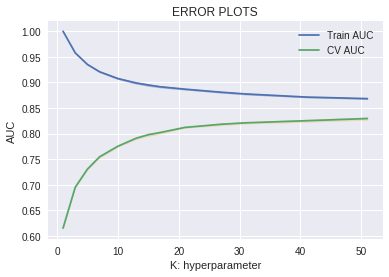

duration =  1:02:05.875448


In [0]:
Knn(algo="brute",X_train=Bow_train, X_test = Bow_test , y_train=y_train, y_test=y_test)

#### testing On best neighbour

Accuracy on test set: 88.737%
Precision on test set: 0.889
Recall on test set: 0.996
F1-Score on test set: 0.939


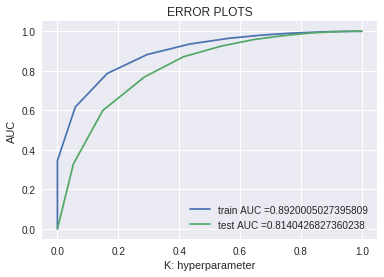

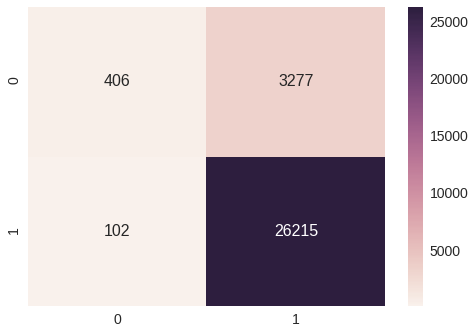

In [0]:
Knn_test(neigh=20,algo="brute",X_train=Bow_train, X_test = Bow_test , y_train=y_train, y_test=y_test)

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed: 67.6min finished


n_neighbors 51


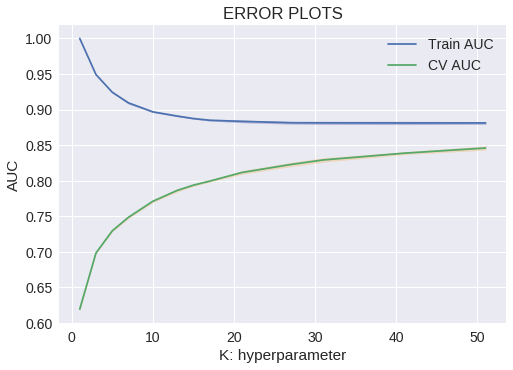

duration =  1:07:34.639967


In [0]:
Knn(algo="brute",X_train=tf_idf_train, X_test = tf_idf_test , y_train=y_train, y_test=y_test)

#### testing On best neighbour

Accuracy on test set: 88.930%
Precision on test set: 0.890
Recall on test set: 0.997
F1-Score on test set: 0.940


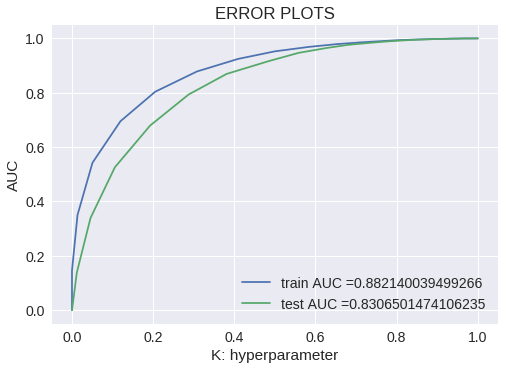

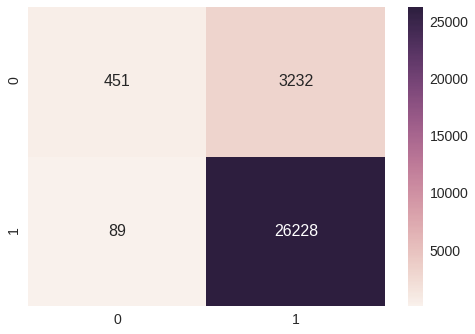

In [0]:
Knn_test(neigh=30,algo="brute",X_train=tf_idf_train, X_test = tf_idf_test , y_train=y_train, y_test=y_test)

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed: 79.3min finished


n_neighbors 51


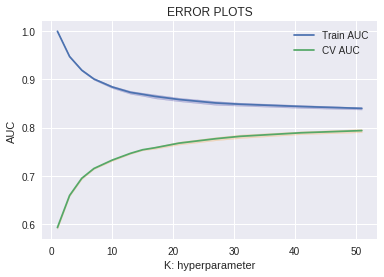

duration =  1:19:17.625845


In [0]:
Knn(algo="brute",X_train=avg_train, X_test = avg_test , y_train=y_train, y_test=y_test)

#### testing On best neighbour

Accuracy on test set: 88.140%
Precision on test set: 0.883
Recall on test set: 0.997
F1-Score on test set: 0.937


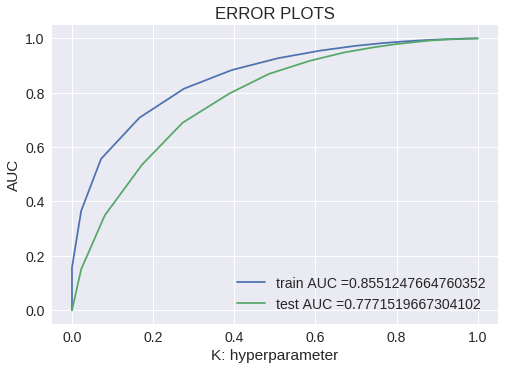

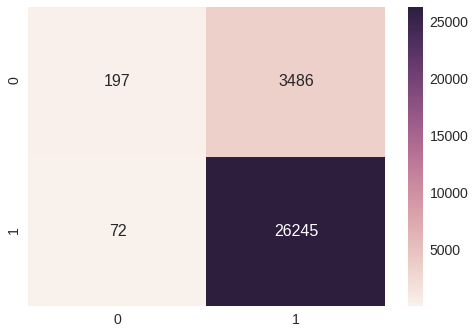

In [0]:
Knn_test(neigh=30,algo="brute",X_train=avg_train, X_test = avg_test , y_train=y_train, y_test=y_test)

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed: 72.4min finished


n_neighbors 51


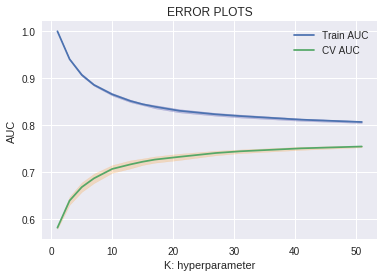

duration =  1:12:23.357481


In [0]:
Knn(algo="brute",X_train = w2v_tfidf_train , X_test = w2v_tfidf_test , y_train=y_train_word, y_test=y_test)



#### testing On best neighbour

Accuracy on test set: 87.536%
Precision on test set: 0.880
Recall on test set: 0.993
F1-Score on test set: 0.933


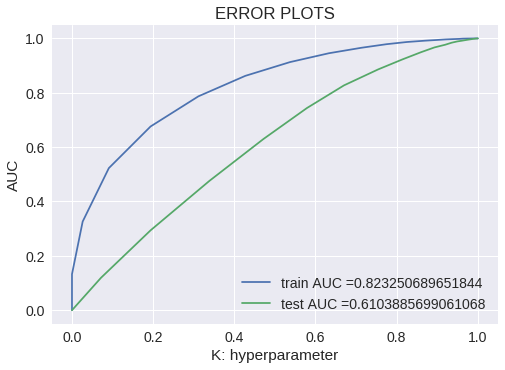

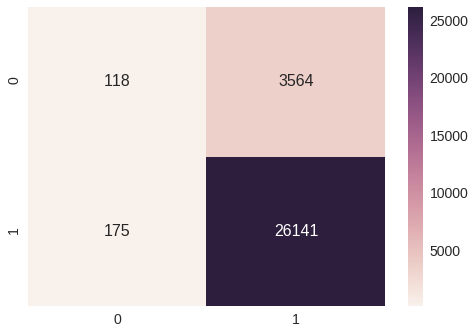

In [0]:
Knn_test(neigh=30,algo="brute",X_train = w2v_tfidf_train , X_test = w2v_tfidf_test , y_train=y_train_word, y_test=y_test_word)

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [0]:
Bow_kd_train = Bow_kd_train.toarray() 
Bow_kd_test = Bow_kd_test.toarray() 

In [0]:
type(Bow_kd_test)

numpy.ndarray

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed: 73.9min finished


n_neighbors 51


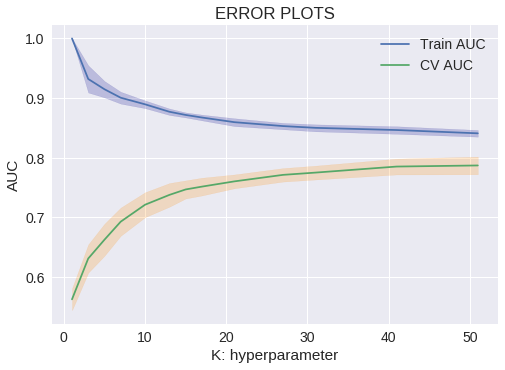

duration =  1:13:53.501122


In [0]:
Knn(algo="kd_tree",X_train=Bow_kd_train, X_test = Bow_kd_test , y_train=y_train_kd, y_test=y_test_kd)

#### testing On best neighbour

Accuracy on test set: 88.883%
Precision on test set: 0.890
Recall on test set: 0.998
F1-Score on test set: 0.941


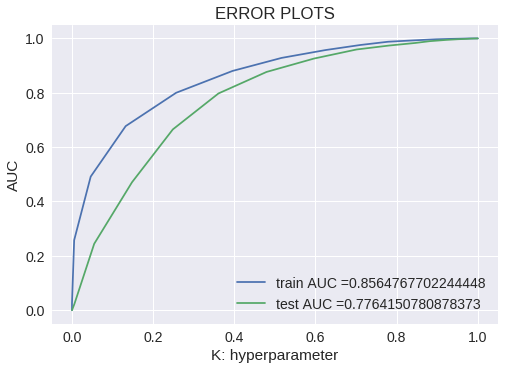

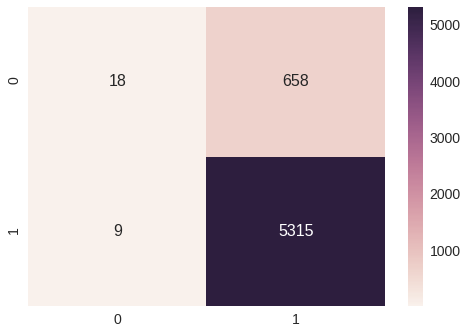

In [0]:
Knn_test(neigh=27,algo="kd_tree",X_train=Bow_kd_train, X_test = Bow_kd_test , y_train=y_train_kd, y_test=y_test_kd)

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [0]:
tf_idf_kd_train = tf_idf_kd_train.toarray() 
tf_idf_kd_test = tf_idf_kd_test.toarray() 

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed: 72.4min finished


n_neighbors 51


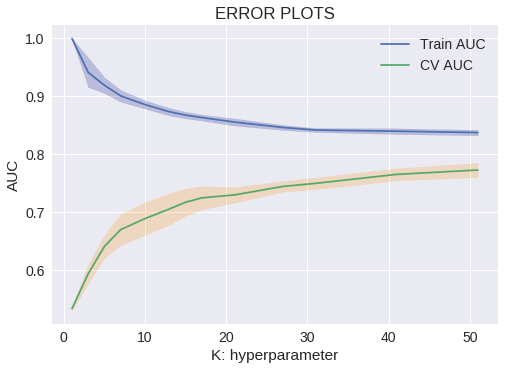

duration =  1:12:24.219280


In [0]:
Knn(algo="kd_tree",X_train=tf_idf_kd_train, X_test = tf_idf_kd_test , y_train=y_train_kd, y_test=y_test_kd)

#### testing On best neighbour

Accuracy on test set: 88.867%
Precision on test set: 0.889
Recall on test set: 1.000
F1-Score on test set: 0.941


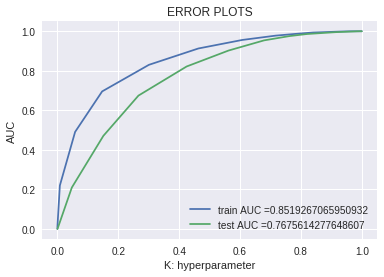

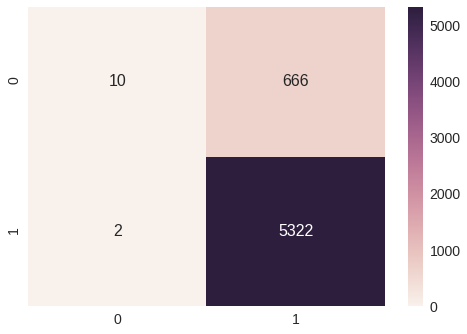

In [0]:
Knn_test(neigh=27,algo="kd_tree",X_train=tf_idf_kd_train, X_test = tf_idf_kd_test , y_train=y_train_kd, y_test=y_test_kd)

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed: 51.8min finished


n_neighbors 51


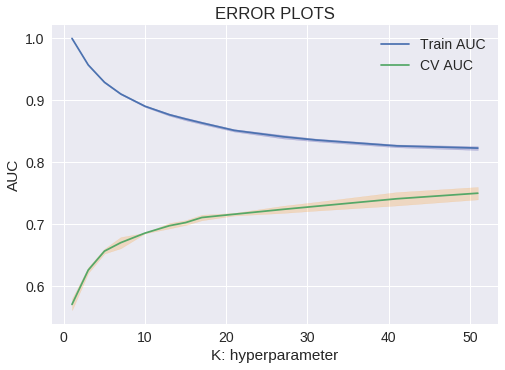

duration =  0:51:49.086639


In [101]:
Knn(algo="kd_tree",X_train=avg_train, X_test = avg_test , y_train=y_train_kd, y_test=y_test_kd)

#### testing On best neighbour

Accuracy on test set: 89.050%
Precision on test set: 0.890
Recall on test set: 1.000
F1-Score on test set: 0.942


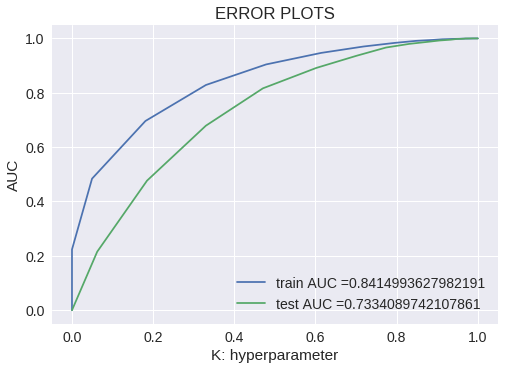

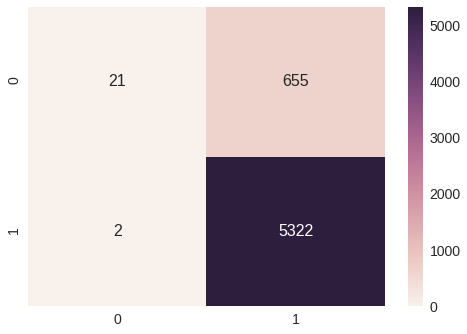

In [103]:
Knn_test(neigh=30,algo="kd_tree",X_train=avg_train, X_test = avg_test , y_train=y_train_kd, y_test=y_test_kd)

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed: 51.7min finished


n_neighbors 51


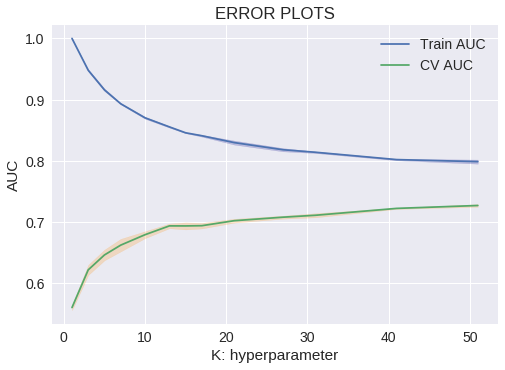

duration =  0:51:39.582213


In [102]:
Knn(algo="kd_tree",X_train = w2v_tfidf_train , X_test = w2v_tfidf_test , y_train=y_train_word, y_test=y_test)


#### testing On best neighbour

Accuracy on test set: 88.733%
Precision on test set: 0.887
Recall on test set: 1.000
F1-Score on test set: 0.940


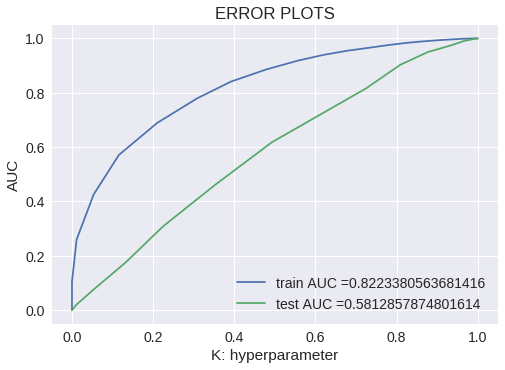

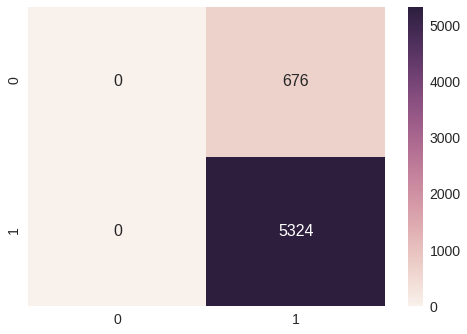

In [0]:
Knn_test(neigh=40,algo="kd_tree", X_train=w2v_tfidf_kd_train , X_test = w2v_tfidf_kd_test , y_train=y_train_kd, y_test=y_test_kd)

# [6] Conclusions

|Vectorizer|Model|Hyper Parameter|Accuracy |Precision |Recall |F1-Score |
|-------|-----|---|
|Bow|Brute|20|88.737%|0.889|0.996| 0.939|
|Tfidf|Brute|30|88.930%|0.890|0.997|0.940|
|Avg w2v|Brute|30|88.140%|0.883|0.997|0.937|
|Tfidf w2v|Brute|30|87.536%|0.883|0.983|0.933|
|Bow|Kd_tree|27|88.883%|0.890|0.998|0.941|
|Tfidf|Kd_tree|27|88.867%|0.889| 1.000|0.941|
|Avg w2v|Kd_tree|30|88.717%|0.887|1.000|0.940|
|Tfidf w2v|Kd_tree|40|88.733%|0.887| 1.000|0.940|

* As we See that best accuracy is 89.153% at Tfidf.
* Kd tree and Brute both gives relatively similar results
* Knn is not good for this dataset.
* Knn take long time to train.